In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init

torch.manual_seed(24)

MASS = 1.0
HBAR = 1.0
AUTOEV = 27.2114
AUTONM = 0.05291772108

# qGrid: 0.0 to 5.0; NGRID = 1024; 
# rGrid: 0.0 to 0.02*TWOPI / (NGRID * dq)    --> 0.0 to 25.7108; NGRID = 1024; 
NQGRID = 2048
qGrid = torch.linspace(0.0, 10.0, NQGRID, dtype=torch.float64)
dq = (10.0-0.0)/NQGRID

In [2]:
def plotBandStruct(bandStruct_array, marker_array, label_array): 
    fig, axs = plt.subplots(1,1, figsize=(3,3))
    for bandStructIndex in range(len(bandStruct_array)): 
        numBands = len(bandStruct_array[bandStructIndex][0])
        numKpts = len(bandStruct_array[bandStructIndex])
        for i in range(numBands): 
            if i==0: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex], label=label_array[bandStructIndex])
            else: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex])
    axs.legend(frameon=False)
    plt.show()
    return

def pot_func(x, params): 
    pot = (params[0]*(x*x - params[1]) / (params[2] * np.exp(params[3]*x*x) - 1.0))
    return pot
    
def plotPP(q_array, vq_Cd_array, vq_Se_array, label_array, lineshape_array): 
    fig, axs = plt.subplots(1,1, figsize=(3,3))
    for i in range(len(vq_Cd_array)): 
        q = q_array[i].detach().numpy()
        vq_Cd = vq_Cd_array[i].detach().numpy()
        vq_Se = vq_Se_array[i].detach().numpy()
        axs.plot(q, vq_Cd, lineshape_array[i], label="Cd "+label_array[i])
        axs.plot(q, vq_Se, lineshape_array[i], label="Se "+label_array[i])
    axs.set(xlabel=r"$q$", ylabel=r"$v(q)$")
    axs.legend(frameon=False)
    plt.show()
    return

In [3]:
# Semiconductor system details

nSystem = 1

# read system
scale = 11.4485278
unitCellVector1 = torch.tensor([0.0, 0.5, 0.5], dtype=torch.float64) * scale
unitCellVector2 = torch.tensor([0.5, 0.0, 0.5], dtype=torch.float64) * scale
unitCellVector3 = torch.tensor([0.5, 0.5, 0.0], dtype=torch.float64) * scale
unitCellVectors = torch.cat((unitCellVector1.unsqueeze(0), unitCellVector2.unsqueeze(0), unitCellVector3.unsqueeze(0)), dim=0)
cellVolume = torch.dot(unitCellVector1, torch.cross(unitCellVector2, unitCellVector3))

# calculate reciprocal space vectors
prefactor = 2 * np.pi / cellVolume
gVector1 = prefactor * torch.cross(unitCellVectors[1], unitCellVectors[2])
gVector2 = prefactor * torch.cross(unitCellVectors[2], unitCellVectors[0])
gVector3 = prefactor * torch.cross(unitCellVectors[0], unitCellVectors[1])
gVectors = torch.cat((gVector1.unsqueeze(0), gVector2.unsqueeze(0), gVector3.unsqueeze(0)), dim=0)

nAtoms = 2
atomTypes = np.array(["Cd", "Se"])
atomPos = torch.tensor([[0.125, 0.125, 0.125],
                        [-0.125, -0.125, -0.125]], dtype=torch.float64)
atomPos = atomPos @ unitCellVectors
# print(atomPos)

# read kPoints
kpt_zbCdSe = torch.tensor(np.loadtxt("ZB_kpoints.par"))
kpt_zbCdSe = kpt_zbCdSe @ gVectors
nkpt = kpt_zbCdSe.shape[0]
# Gamma = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float64)

# read band strcture
Eref_zbCdSe = torch.tensor(np.loadtxt("bandStruct_zbCdSe.par")[:, 1:])

maxKE = 10

nBands = 16

In [4]:
# Current Cd, Se, S pp's in Zunger's form
CdParams = torch.tensor([-31.4518, 1.3890, -0.0502, 1.6603, 0.0586], dtype=torch.float64)
SeParams = torch.tensor([8.4921, 4.3513, 1.3600, 0.3227, 0.1746], dtype=torch.float64)
SParams = torch.tensor([7.6697, 4.5192, 1.3456, 0.3035, 0.2087], dtype=torch.float64)
PP_order = np.array(["Cd", "Se", "S"])
totalParams = torch.cat((CdParams.unsqueeze(0), SeParams.unsqueeze(0), SParams.unsqueeze(0)), dim=0)

CdPP = pot_func(qGrid, CdParams)
SePP = pot_func(qGrid, SeParams)
# totalPP = torch.cat((CdPP.unsqueeze(0), SePP.unsqueeze(0)), dim=0)

In [5]:
def basis(maxKE, scale, unitCellVectors, gVectors, cellVolume): 
    minGMag = min(torch.norm(gVectors[0]), torch.norm(gVectors[1]), torch.norm(gVectors[2]))
    numMaxBasisVectors = int(np.sqrt(2*maxKE) / minGMag)
    # print(numMaxBasisVectors)

    k = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat((2*numMaxBasisVectors+1)**2)
    j = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)).repeat((2*numMaxBasisVectors+1))
    i = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)**2)
    allGrid = torch.vstack((i, j, k)).T
    transform = gVectors.T
    allBasisSet = allGrid @ transform
    # print(allBasisSet.shape[0])
    # print(allBasisSet)

    row_norms = torch.norm(allBasisSet, dim=1)
    condition = (HBAR*0.5*row_norms**2 / MASS < maxKE)
    indices = torch.where(condition)[0]
    basisSet = allBasisSet[indices]
    # print(basisSet.shape[0])
    # print(basisSet)
    
    sorting_indices = torch.argsort(basisSet[:, 2], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 1], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 0], stable=True)
    basisSet = basisSet[sorting_indices]
    row_norms = torch.norm(basisSet, dim=1)
    sorting_indices = torch.argsort(row_norms[:], stable=True)
    sorted_basisSet = basisSet[sorting_indices]
    
    return sorted_basisSet

# construct hamiltonian at a certain k-point (kVector). Quicker through vectorization. 
def calcHamiltonianMatrix(NN_boolean, basisStates, kVector, nAtoms, cellVolume):
    n = basisStates.shape[0]
    HMatrix = torch.zeros((n, n), dtype=torch.complex128)

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (torch.norm(basisStates[i] + kVector))**2
        
    # Local potential
    gDiff = torch.stack([basisStates] * (basisStates.shape[0]), dim=1) - basisStates.repeat(basisStates.shape[0], 1, 1)
    
    for k in range(nAtoms): 
        gDiffDotTau = torch.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (torch.cos(gDiffDotTau) + 1j*torch.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        
        if NN_boolean: 
            atomFF = PPmodel(torch.norm(gDiff, dim=2).view(-1, 1))
            atomFF = atomFF[:, thisAtomIndex].view(n, n)
        else: 
            atomFF = pot_func(torch.norm(gDiff, dim=2), totalParams[thisAtomIndex])
        
        HMatrix += atomFF * structFact
    return HMatrix

def calcBandStruct(NN_boolean, basisStates, nkpt, kpts_coord, nAtoms, cellVolume, nBands): 
    bandStruct = torch.zeros((nkpt, nBands), dtype=torch.float64)
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix(NN_boolean, basisStates, kpts_coord[kpt_index], nAtoms, cellVolume)

        # diagonalize the hamiltonian
        energies = torch.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        
        energiesEV = energies * AUTOEV
        # 2-fold degeneracy due to spin
        final_energies = energiesEV.repeat_interleave(2)[:nBands]
    
        bandStruct[kpt_index] = final_energies

    return bandStruct

tensor([[ 0.8000, -1.7540],
        [ 0.7114,  0.9516]], dtype=torch.float64, grad_fn=<AddmmBackward0>)


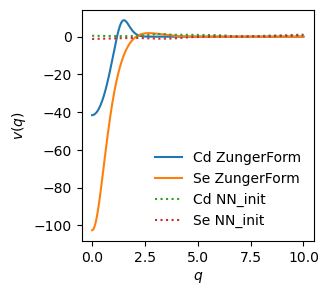

In [6]:
# Create Net model class
'''
class Net(nn.Module):
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        self.batch_norm = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            layer = nn.Linear(input_size, output_size, dtype=torch.float64)
            init.xavier_normal_(layer.weight)
            init.constant_(layer.bias, 0)
            self.hidden.append(layer)
            if output_size != Layers[-1]:
                self.batch_norm.append(nn.BatchNorm1d(output_size, dtype=torch.float64))
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in enumerate(self.hidden):
            if l < L - 1:
                activation = torch.relu(linear_transform(activation))
                activation = self.batch_norm[l](activation)
            else:
                activation = linear_transform(activation)
        return activation

Layers = [1, 20, 2]
PPmodel = Net(Layers)
'''

# Added batch normalization, xavier initialization
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = nn.Linear(1, 20, dtype=torch.float64) 
        self.bn1 = nn.BatchNorm1d(20, dtype=torch.float64) 

        self.hidden_layer1 = nn.Linear(20, 20, dtype=torch.float64) 
        self.bn2 = nn.BatchNorm1d(20, dtype=torch.float64)  

        self.hidden_layer2 = nn.Linear(20, 20, dtype=torch.float64) 
        self.bn3 = nn.BatchNorm1d(20, dtype=torch.float64) 

        self.output_layer = nn.Linear(20, 2, dtype=torch.float64) 

        # Xavier initialization for weights
        init.xavier_normal_(self.input_layer.weight)
        init.xavier_normal_(self.hidden_layer1.weight)
        init.xavier_normal_(self.hidden_layer2.weight)
        init.xavier_normal_(self.output_layer.weight)

    def forward(self, x):
        x = torch.relu(self.bn1(self.input_layer(x)))  
        x = torch.relu(self.bn2(self.hidden_layer1(x)))
        x = torch.relu(self.bn3(self.hidden_layer2(x)))
        x = self.output_layer(x)
        return x

PPmodel = Net()


# print("list(model.parameters()):\n ", list(PPmodel.parameters()))
# print("\nmodel.state_dict():\n ", PPmodel.state_dict())
print(PPmodel(torch.tensor([[1.0], [2.0]], dtype=torch.float64)))
# print(PPmodel(torch.tensor([[1.0]], dtype=torch.float64)))

# Validating on the initialized NN model
NN_init = PPmodel(qGrid.view(-1, 1))
plotPP([qGrid, qGrid], [CdPP, NN_init[:, 0]], [SePP, NN_init[:, 1]], ["ZungerForm", "NN_init"], ["-", ":"])

Epoch [100/1000], Loss: 3.1647


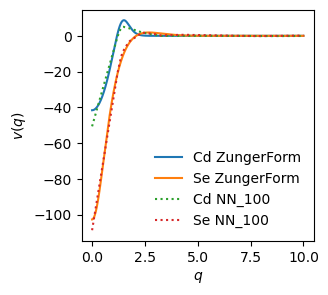

Epoch [200/1000], Loss: 2.1834


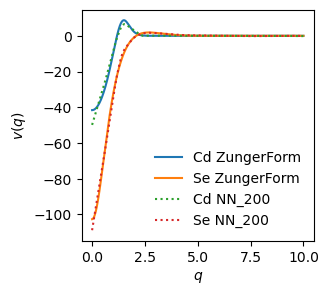

Epoch [300/1000], Loss: 1.3577


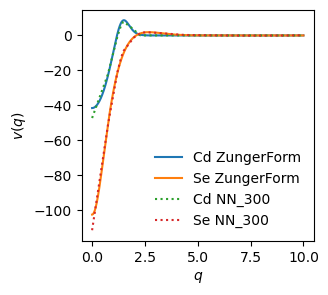

Epoch [400/1000], Loss: 0.7877


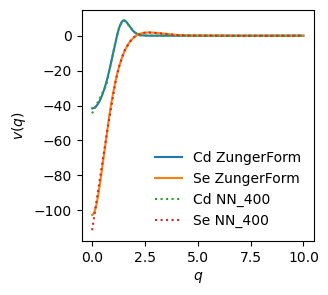

Epoch [500/1000], Loss: 0.6248


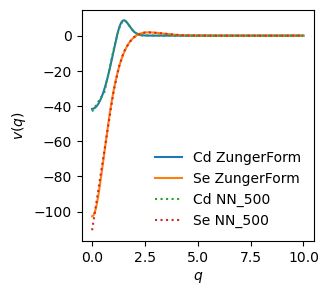

Epoch [600/1000], Loss: 0.4052


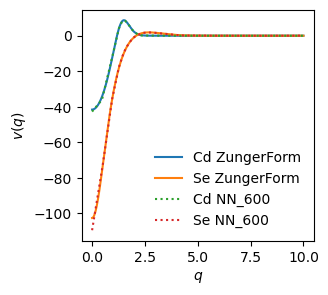

Epoch [700/1000], Loss: 0.2078


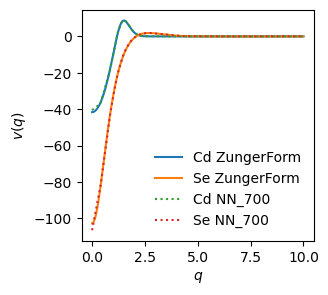

Epoch [800/1000], Loss: 0.0800


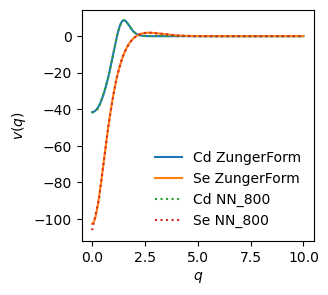

Epoch [900/1000], Loss: 0.0589


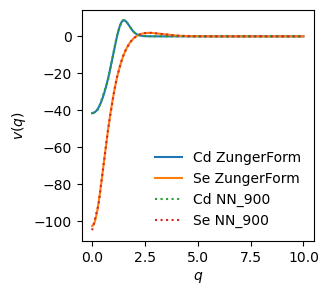

Epoch [1000/1000], Loss: 0.0507


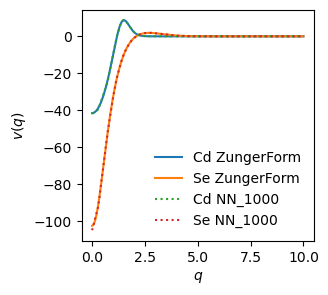

In [7]:
# Initialize the NN parameters to fit the current Zunger form
def totalMSELoss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.1)
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    inputs = qGrid.reshape(-1, 1)
    CdOutputs = PPmodel(inputs)[:,0]
    SeOutputs = PPmodel(inputs)[:,1]
    
    CdTargets = torch.zeros_like(CdOutputs)
    SeTargets = torch.zeros_like(CdOutputs)
    for i, x in enumerate(qGrid):
        CdTargets[i] = pot_func(x, CdParams)
        SeTargets[i] = pot_func(x, SeParams)
    
    loss = totalMSELoss(CdOutputs, CdTargets) + totalMSELoss(SeOutputs, SeTargets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        NN_init = PPmodel(qGrid.view(-1, 1))
        plotPP([qGrid, qGrid], [CdPP, NN_init[:, 0]], [SePP, NN_init[:, 1]], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"]);

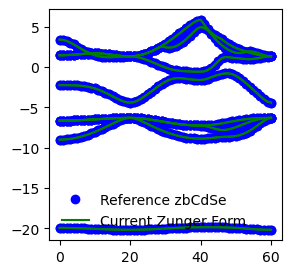

Using the this code, can I reproduce the reference band structure to within 1e-11 eV? 
True


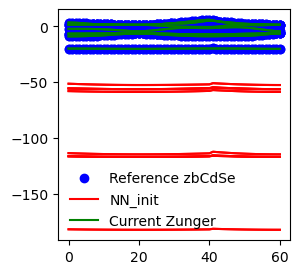

In [8]:
basisStates = basis(maxKE, scale, unitCellVectors, gVectors, cellVolume)

current_Zunger_BandStruct = calcBandStruct(False, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, current_Zunger_BandStruct], ["bo", "g-"], ["Reference zbCdSe", "Current Zunger Form"])
print("Using the this code, can I reproduce the reference band structure to within 1e-11 eV? ")
print(torch.allclose(Eref_zbCdSe, current_Zunger_BandStruct, atol=1e-11))

NN_init_BandStruct = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, NN_init_BandStruct, current_Zunger_BandStruct], ["bo", "r-", "g-"], ["Reference zbCdSe", "NN_init", "Current Zunger"])

Loss: 9298.017150841859
Parameter: input_layer.weight, Gradient Norm: 0.07185850810271249
Parameter: input_layer.bias, Gradient Norm: 1.3253916655625782e-11
Parameter: bn1.weight, Gradient Norm: 3452.9025709479765
Parameter: bn1.bias, Gradient Norm: 3662.7852613224422
Parameter: hidden_layer1.weight, Gradient Norm: 1627.9097229836082
Parameter: hidden_layer1.bias, Gradient Norm: 2.9889663876896084e-12
Parameter: bn2.weight, Gradient Norm: 2797.997296483793
Parameter: bn2.bias, Gradient Norm: 1629.7575708987606
Parameter: hidden_layer2.weight, Gradient Norm: 2354.9902795789662
Parameter: hidden_layer2.bias, Gradient Norm: 4.5240306207237465e-12
Parameter: bn3.weight, Gradient Norm: 7341.004336142954
Parameter: bn3.bias, Gradient Norm: 3456.2833646883587
Parameter: output_layer.weight, Gradient Norm: 11143.659300160252
Parameter: output_layer.bias, Gradient Norm: 693.8541281950298
Loss: 1885.2757662281151
Parameter: input_layer.weight, Gradient Norm: 0.04044890810898994
Parameter: input_

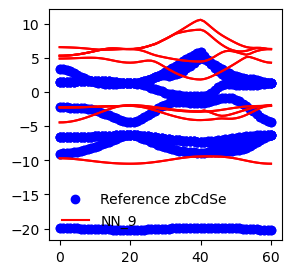

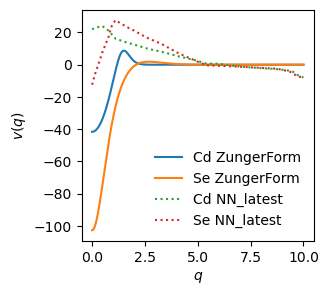

Loss: 34.24928097945506
Parameter: input_layer.weight, Gradient Norm: 0.03105789072024752
Parameter: input_layer.bias, Gradient Norm: 1.7613263381541424e-12
Parameter: bn1.weight, Gradient Norm: 87.68197138222709
Parameter: bn1.bias, Gradient Norm: 38.95369970016856
Parameter: hidden_layer1.weight, Gradient Norm: 38.01397164048103
Parameter: hidden_layer1.bias, Gradient Norm: 9.170837208228143e-13
Parameter: bn2.weight, Gradient Norm: 66.27803661480205
Parameter: bn2.bias, Gradient Norm: 21.177208965504324
Parameter: hidden_layer2.weight, Gradient Norm: 94.8854371654828
Parameter: hidden_layer2.bias, Gradient Norm: 1.0419335614088005e-13
Parameter: bn3.weight, Gradient Norm: 89.03883085546137
Parameter: bn3.bias, Gradient Norm: 12.331683818856904
Parameter: output_layer.weight, Gradient Norm: 113.04962861006685
Parameter: output_layer.bias, Gradient Norm: 0.04328409980000643


In [10]:
learning_rate = 0.1
optimizer = torch.optim.Adam(PPmodel.parameters(), lr = learning_rate)

# torch.autograd.set_detect_anomaly(False)

def train_model(epochs):
    for epoch in range(epochs):
        # for name, param in PPmodel.named_parameters():
        #     print(f"Parameter: {name}, Size: {param.size()}")
        #     print(param.data)
        NN_BandStruct = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
        
        if (epoch + 1) % 10 == 0:
            plotBandStruct([Eref_zbCdSe, NN_BandStruct], ["bo", "r-"], ["Reference zbCdSe", "NN_"+str(epoch)])
            NN_latest = PPmodel(qGrid.view(-1, 1))
            plotPP([qGrid, qGrid], [CdPP, NN_latest[:, 0]], [SePP, NN_latest[:, 1]], ["ZungerForm", "NN_latest"], ["-", ":"])
        
        loss = ((Eref_zbCdSe - NN_BandStruct) ** 2).mean()
        print(f"Loss: {loss}")
        optimizer.zero_grad()
        loss.backward()
        for name, param in PPmodel.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient Norm: {param.grad.norm().item()}")
        optimizer.step()

train_model(10)

Loss: 7.804893265027128
Parameter: input_layer.weight, Gradient Norm: 0.14181815277737986
Parameter: input_layer.bias, Gradient Norm: 6.340309549009837e-13
Parameter: bn1.weight, Gradient Norm: 28.017800569696345
Parameter: bn1.bias, Gradient Norm: 12.275048157865625
Parameter: hidden_layer1.weight, Gradient Norm: 10.058875236352439
Parameter: hidden_layer1.bias, Gradient Norm: 1.459350146036096e-13
Parameter: bn2.weight, Gradient Norm: 19.612165410656903
Parameter: bn2.bias, Gradient Norm: 7.047222403322271
Parameter: hidden_layer2.weight, Gradient Norm: 33.747227286889604
Parameter: hidden_layer2.bias, Gradient Norm: 7.803552312122774e-14
Parameter: bn3.weight, Gradient Norm: 33.35132854047606
Parameter: bn3.bias, Gradient Norm: 5.322798518581221
Parameter: output_layer.weight, Gradient Norm: 42.85710126936252
Parameter: output_layer.bias, Gradient Norm: 0.0293827895536797
Loss: 5.056112079846545
Parameter: input_layer.weight, Gradient Norm: 0.0023564359006803827
Parameter: input_lay

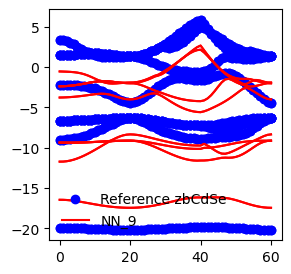

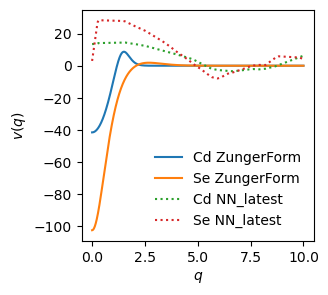

Loss: 8.69613094226308
Parameter: input_layer.weight, Gradient Norm: 0.0019623312343223565
Parameter: input_layer.bias, Gradient Norm: 3.0264673397320374e-13
Parameter: bn1.weight, Gradient Norm: 50.110215115841754
Parameter: bn1.bias, Gradient Norm: 21.266870657639963
Parameter: hidden_layer1.weight, Gradient Norm: 191.41031159633098
Parameter: hidden_layer1.bias, Gradient Norm: 9.393646494178345e-13
Parameter: bn2.weight, Gradient Norm: 23.782304834544178
Parameter: bn2.bias, Gradient Norm: 15.542080788038067
Parameter: hidden_layer2.weight, Gradient Norm: 29.61199831954947
Parameter: hidden_layer2.bias, Gradient Norm: 4.3336167371382465e-14
Parameter: bn3.weight, Gradient Norm: 30.820478742792133
Parameter: bn3.bias, Gradient Norm: 4.294289120632946
Parameter: output_layer.weight, Gradient Norm: 42.980254031978134
Parameter: output_layer.bias, Gradient Norm: 0.013564761761332053
Loss: 4.2432058103282255
Parameter: input_layer.weight, Gradient Norm: 0.0002666742669116402
Parameter: i

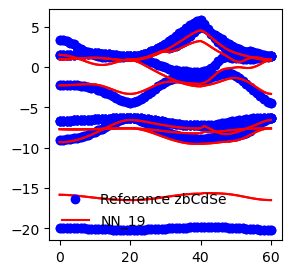

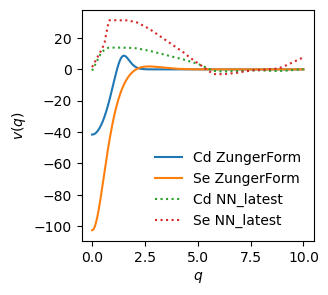

Loss: 2.5937947192706776
Parameter: input_layer.weight, Gradient Norm: 0.00017652980306415457
Parameter: input_layer.bias, Gradient Norm: 6.884636415994568e-14
Parameter: bn1.weight, Gradient Norm: 13.597194251137712
Parameter: bn1.bias, Gradient Norm: 7.519349644996512
Parameter: hidden_layer1.weight, Gradient Norm: 25.208156932855218
Parameter: hidden_layer1.bias, Gradient Norm: 4.328068257812342e-14
Parameter: bn2.weight, Gradient Norm: 0.8120869221404518
Parameter: bn2.bias, Gradient Norm: 0.693145401358969
Parameter: hidden_layer2.weight, Gradient Norm: 1.6935886762006385
Parameter: hidden_layer2.bias, Gradient Norm: 1.5120509302107756e-15
Parameter: bn3.weight, Gradient Norm: 1.381445007886043
Parameter: bn3.bias, Gradient Norm: 0.8670487814404164
Parameter: output_layer.weight, Gradient Norm: 2.773804041624925
Parameter: output_layer.bias, Gradient Norm: 0.04139789818062215
Loss: 2.4476794422939205
Parameter: input_layer.weight, Gradient Norm: 0.000181803895679194
Parameter: inp

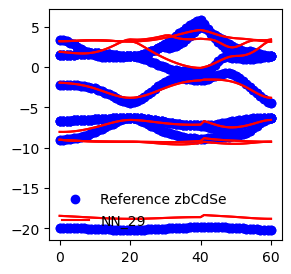

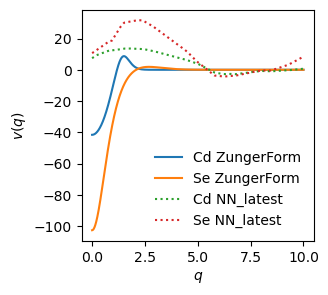

Loss: 2.0065624435085403
Parameter: input_layer.weight, Gradient Norm: 6.358988063038151e-05
Parameter: input_layer.bias, Gradient Norm: 4.002758607779579e-14
Parameter: bn1.weight, Gradient Norm: 7.113448137285897
Parameter: bn1.bias, Gradient Norm: 3.572531157289519
Parameter: hidden_layer1.weight, Gradient Norm: 4.944161509083256
Parameter: hidden_layer1.bias, Gradient Norm: 4.3796370166609956e-15
Parameter: bn2.weight, Gradient Norm: 4.442998498197738
Parameter: bn2.bias, Gradient Norm: 3.0649890771146815
Parameter: hidden_layer2.weight, Gradient Norm: 5.745696321101719
Parameter: hidden_layer2.bias, Gradient Norm: 1.5369015525447273e-14
Parameter: bn3.weight, Gradient Norm: 5.626296239645151
Parameter: bn3.bias, Gradient Norm: 2.3472933813022783
Parameter: output_layer.weight, Gradient Norm: 8.191825988565137
Parameter: output_layer.bias, Gradient Norm: 0.03208096537977205
Loss: 1.925087346733318
Parameter: input_layer.weight, Gradient Norm: 6.744379970735001e-05
Parameter: input_

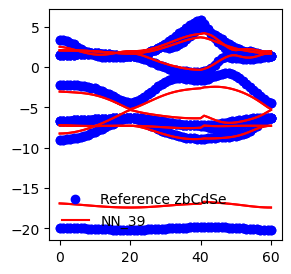

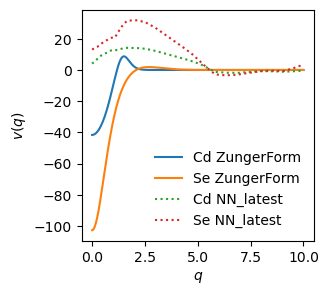

Loss: 1.4312113713342496
Parameter: input_layer.weight, Gradient Norm: 3.522536049974416e-05
Parameter: input_layer.bias, Gradient Norm: 6.7369675849517114e-15
Parameter: bn1.weight, Gradient Norm: 4.4318594907565005
Parameter: bn1.bias, Gradient Norm: 3.2621062049499088
Parameter: hidden_layer1.weight, Gradient Norm: 6.344176256667868
Parameter: hidden_layer1.bias, Gradient Norm: 1.3928797138782037e-14
Parameter: bn2.weight, Gradient Norm: 3.61368874733633
Parameter: bn2.bias, Gradient Norm: 1.9352190482338198
Parameter: hidden_layer2.weight, Gradient Norm: 3.751046397042839
Parameter: hidden_layer2.bias, Gradient Norm: 1.0362300463034889e-14
Parameter: bn3.weight, Gradient Norm: 5.996011038474113
Parameter: bn3.bias, Gradient Norm: 1.8625463405182476
Parameter: output_layer.weight, Gradient Norm: 7.4234154444779294
Parameter: output_layer.bias, Gradient Norm: 0.06160488112268133
Loss: 1.3951162526779652
Parameter: input_layer.weight, Gradient Norm: 3.2471680520421564e-05
Parameter: i

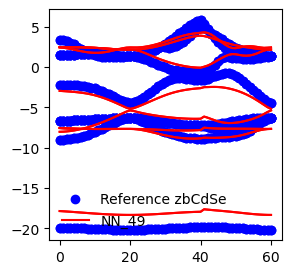

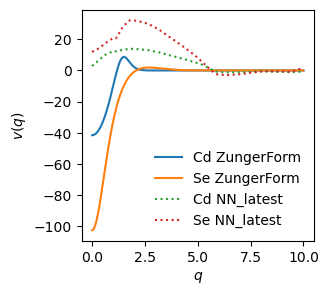

Loss: 1.0581694221432316
Parameter: input_layer.weight, Gradient Norm: 1.8769112951633706e-05
Parameter: input_layer.bias, Gradient Norm: 1.2174998699180895e-14
Parameter: bn1.weight, Gradient Norm: 2.3564586787792763
Parameter: bn1.bias, Gradient Norm: 1.5768888638612133
Parameter: hidden_layer1.weight, Gradient Norm: 4.029400242366859
Parameter: hidden_layer1.bias, Gradient Norm: 4.0684078019357075e-15
Parameter: bn2.weight, Gradient Norm: 1.9221130867384622
Parameter: bn2.bias, Gradient Norm: 0.8510084174680695
Parameter: hidden_layer2.weight, Gradient Norm: 1.4492049038216692
Parameter: hidden_layer2.bias, Gradient Norm: 3.1898262674519236e-15
Parameter: bn3.weight, Gradient Norm: 2.800086567686592
Parameter: bn3.bias, Gradient Norm: 0.8168855128014982
Parameter: output_layer.weight, Gradient Norm: 3.3752111496377286
Parameter: output_layer.bias, Gradient Norm: 0.045029436932143604


In [11]:
train_model(50)

Loss: 1.041032279922008
Parameter: input_layer.weight, Gradient Norm: 1.746202206149912e-05
Parameter: input_layer.bias, Gradient Norm: 1.1985883765719566e-14
Parameter: bn1.weight, Gradient Norm: 2.2387350070235152
Parameter: bn1.bias, Gradient Norm: 1.4355076750922537
Parameter: hidden_layer1.weight, Gradient Norm: 4.414673720071797
Parameter: hidden_layer1.bias, Gradient Norm: 9.764064182985305e-15
Parameter: bn2.weight, Gradient Norm: 1.9322497286931382
Parameter: bn2.bias, Gradient Norm: 0.8404742826815224
Parameter: hidden_layer2.weight, Gradient Norm: 1.39072079913813
Parameter: hidden_layer2.bias, Gradient Norm: 4.174912203676644e-15
Parameter: bn3.weight, Gradient Norm: 2.7525424878193703
Parameter: bn3.bias, Gradient Norm: 0.744075462934369
Parameter: output_layer.weight, Gradient Norm: 3.3481501555522675
Parameter: output_layer.bias, Gradient Norm: 0.04290684673084788
Loss: 1.0222442858333758
Parameter: input_layer.weight, Gradient Norm: 1.4466773009470934e-05
Parameter: inp

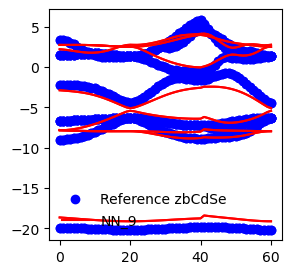

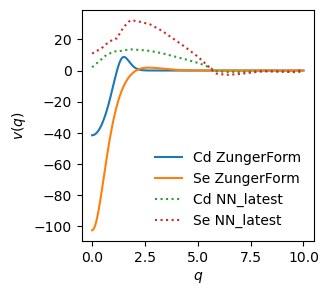

Loss: 0.9459904528595384
Parameter: input_layer.weight, Gradient Norm: 1.0496744119880694e-05
Parameter: input_layer.bias, Gradient Norm: 1.0820622457094548e-14
Parameter: bn1.weight, Gradient Norm: 1.5457063677473868
Parameter: bn1.bias, Gradient Norm: 0.659303583952302
Parameter: hidden_layer1.weight, Gradient Norm: 1.31552794284266
Parameter: hidden_layer1.bias, Gradient Norm: 6.138041349549753e-16
Parameter: bn2.weight, Gradient Norm: 0.6859254920878977
Parameter: bn2.bias, Gradient Norm: 0.4865474951008582
Parameter: hidden_layer2.weight, Gradient Norm: 0.8643842429120907
Parameter: hidden_layer2.bias, Gradient Norm: 1.2128822619968072e-15
Parameter: bn3.weight, Gradient Norm: 0.8801824487378855
Parameter: bn3.bias, Gradient Norm: 0.3262425530257964
Parameter: output_layer.weight, Gradient Norm: 1.6799654343135395
Parameter: output_layer.bias, Gradient Norm: 0.027256124169702845
Loss: 0.9327061020119298
Parameter: input_layer.weight, Gradient Norm: 1.0855348687904573e-05
Parameter

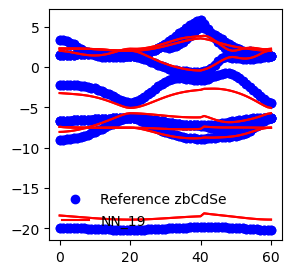

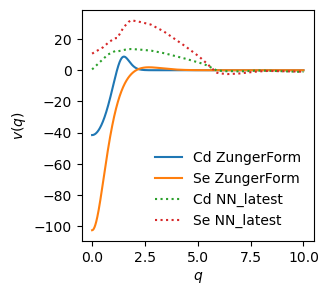

Loss: 0.8051310887097947
Parameter: input_layer.weight, Gradient Norm: 6.5473668580496125e-06
Parameter: input_layer.bias, Gradient Norm: 5.751952693634669e-15
Parameter: bn1.weight, Gradient Norm: 0.8626425862586143
Parameter: bn1.bias, Gradient Norm: 0.8033943265182987
Parameter: hidden_layer1.weight, Gradient Norm: 0.4419680345862049
Parameter: hidden_layer1.bias, Gradient Norm: 1.5290599559475865e-15
Parameter: bn2.weight, Gradient Norm: 0.48175024784820986
Parameter: bn2.bias, Gradient Norm: 0.47604342393462606
Parameter: hidden_layer2.weight, Gradient Norm: 0.29803407741322907
Parameter: hidden_layer2.bias, Gradient Norm: 3.5831172412664493e-16
Parameter: bn3.weight, Gradient Norm: 0.4252976679967344
Parameter: bn3.bias, Gradient Norm: 0.2505986093668869
Parameter: output_layer.weight, Gradient Norm: 0.5350861689608454
Parameter: output_layer.bias, Gradient Norm: 0.03263044860534564
Loss: 0.7978507945042583
Parameter: input_layer.weight, Gradient Norm: 7.137105547286335e-06
Param

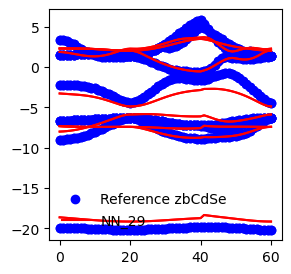

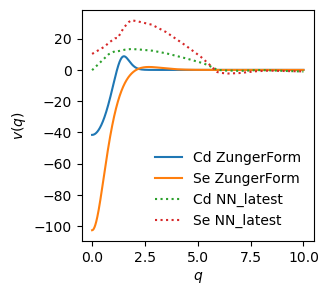

Loss: 0.7208517223884188
Parameter: input_layer.weight, Gradient Norm: 3.199734796128397e-06
Parameter: input_layer.bias, Gradient Norm: 2.839330924094455e-15
Parameter: bn1.weight, Gradient Norm: 0.4365344594712432
Parameter: bn1.bias, Gradient Norm: 0.5832484411741695
Parameter: hidden_layer1.weight, Gradient Norm: 0.7122727979674526
Parameter: hidden_layer1.bias, Gradient Norm: 1.3592889466866908e-15
Parameter: bn2.weight, Gradient Norm: 0.3932784486087
Parameter: bn2.bias, Gradient Norm: 0.4973054372059665
Parameter: hidden_layer2.weight, Gradient Norm: 0.4622663807056964
Parameter: hidden_layer2.bias, Gradient Norm: 4.667690954295779e-16
Parameter: bn3.weight, Gradient Norm: 0.6814271339947621
Parameter: bn3.bias, Gradient Norm: 0.2226708405977357
Parameter: output_layer.weight, Gradient Norm: 0.7993887912746337
Parameter: output_layer.bias, Gradient Norm: 0.02715248246953937
Loss: 0.7124643962356594
Parameter: input_layer.weight, Gradient Norm: 2.4062196073885476e-06
Parameter: i

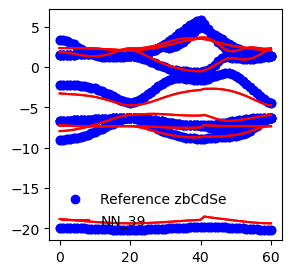

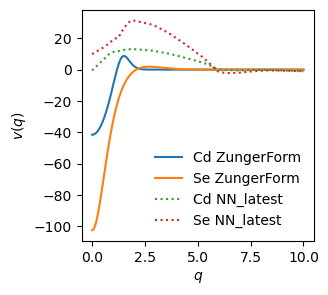

Loss: 0.6573106941260823
Parameter: input_layer.weight, Gradient Norm: 7.68425106132388e-06
Parameter: input_layer.bias, Gradient Norm: 2.6826613621016306e-15
Parameter: bn1.weight, Gradient Norm: 0.887509568924392
Parameter: bn1.bias, Gradient Norm: 0.5867141025357298
Parameter: hidden_layer1.weight, Gradient Norm: 0.3594964385895309
Parameter: hidden_layer1.bias, Gradient Norm: 3.5745920782505865e-16
Parameter: bn2.weight, Gradient Norm: 0.3410987476177311
Parameter: bn2.bias, Gradient Norm: 0.40694138839809946
Parameter: hidden_layer2.weight, Gradient Norm: 0.41744640824408047
Parameter: hidden_layer2.bias, Gradient Norm: 1.1076779646203509e-15
Parameter: bn3.weight, Gradient Norm: 0.5557739887299918
Parameter: bn3.bias, Gradient Norm: 0.1934669858027882
Parameter: output_layer.weight, Gradient Norm: 0.6663450103429039
Parameter: output_layer.bias, Gradient Norm: 0.021902196704062526
Loss: 0.6503651960315386
Parameter: input_layer.weight, Gradient Norm: 5.967215214665e-06
Parameter:

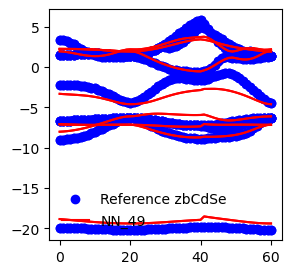

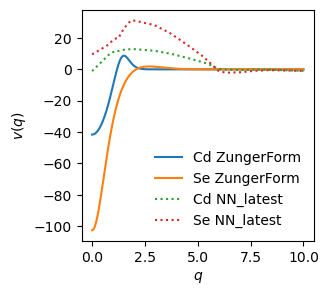

Loss: 0.6023897009709244
Parameter: input_layer.weight, Gradient Norm: 2.345668738685727e-06
Parameter: input_layer.bias, Gradient Norm: 1.7500747494296705e-15
Parameter: bn1.weight, Gradient Norm: 0.3759858502571439
Parameter: bn1.bias, Gradient Norm: 0.5188392988066801
Parameter: hidden_layer1.weight, Gradient Norm: 0.41607059920835543
Parameter: hidden_layer1.bias, Gradient Norm: 4.717949533475878e-15
Parameter: bn2.weight, Gradient Norm: 0.3023288774683102
Parameter: bn2.bias, Gradient Norm: 0.3008001802889529
Parameter: hidden_layer2.weight, Gradient Norm: 0.20205817340742588
Parameter: hidden_layer2.bias, Gradient Norm: 2.738111373628801e-16
Parameter: bn3.weight, Gradient Norm: 0.26076814027930945
Parameter: bn3.bias, Gradient Norm: 0.19101982808251342
Parameter: output_layer.weight, Gradient Norm: 0.3278420559187498
Parameter: output_layer.bias, Gradient Norm: 0.021463902154114953


In [12]:
train_model(50)

Loss: 0.5974031583127108
Parameter: input_layer.weight, Gradient Norm: 2.3424762474325475e-06
Parameter: input_layer.bias, Gradient Norm: 2.0450247625315337e-15
Parameter: bn1.weight, Gradient Norm: 0.39869098135472125
Parameter: bn1.bias, Gradient Norm: 0.5178416777447179
Parameter: hidden_layer1.weight, Gradient Norm: 0.23000886041227464
Parameter: hidden_layer1.bias, Gradient Norm: 1.1206108422829902e-15
Parameter: bn2.weight, Gradient Norm: 0.3530456633402638
Parameter: bn2.bias, Gradient Norm: 0.2714723857543626
Parameter: hidden_layer2.weight, Gradient Norm: 0.16165847428877583
Parameter: hidden_layer2.bias, Gradient Norm: 1.1526860306461704e-16
Parameter: bn3.weight, Gradient Norm: 0.22532327484233702
Parameter: bn3.bias, Gradient Norm: 0.2029371547467144
Parameter: output_layer.weight, Gradient Norm: 0.2648971614544233
Parameter: output_layer.bias, Gradient Norm: 0.021361925712755293
Loss: 0.592618318482326
Parameter: input_layer.weight, Gradient Norm: 2.4315118868029034e-06
Pa

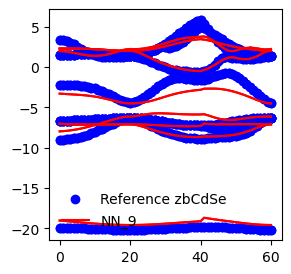

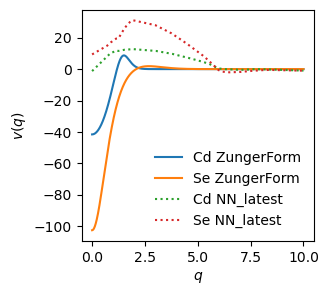

Loss: 0.559460196653189
Parameter: input_layer.weight, Gradient Norm: 2.9309262922247804e-06
Parameter: input_layer.bias, Gradient Norm: 4.275348847453354e-15
Parameter: bn1.weight, Gradient Norm: 0.3895441802043892
Parameter: bn1.bias, Gradient Norm: 0.38607618037307595
Parameter: hidden_layer1.weight, Gradient Norm: 0.2200184400016108
Parameter: hidden_layer1.bias, Gradient Norm: 1.806183289221693e-15
Parameter: bn2.weight, Gradient Norm: 0.253401018976494
Parameter: bn2.bias, Gradient Norm: 0.24624882319411281
Parameter: hidden_layer2.weight, Gradient Norm: 0.22168277515012766
Parameter: hidden_layer2.bias, Gradient Norm: 3.938034334425329e-16
Parameter: bn3.weight, Gradient Norm: 0.20764331967266214
Parameter: bn3.bias, Gradient Norm: 0.14804551906971417
Parameter: output_layer.weight, Gradient Norm: 0.2444079549859337
Parameter: output_layer.bias, Gradient Norm: 0.01682133773577367
Loss: 0.5557136239333187
Parameter: input_layer.weight, Gradient Norm: 2.5721886508269903e-06
Parame

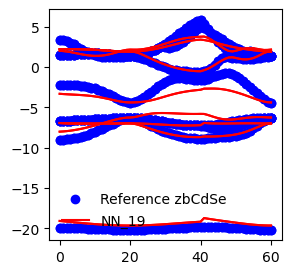

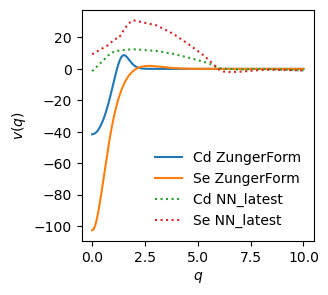

Loss: 0.52581552060794
Parameter: input_layer.weight, Gradient Norm: 1.6500706787856229e-06
Parameter: input_layer.bias, Gradient Norm: 1.1403403284163845e-15
Parameter: bn1.weight, Gradient Norm: 0.26581986977423616
Parameter: bn1.bias, Gradient Norm: 0.34625958045526933
Parameter: hidden_layer1.weight, Gradient Norm: 0.13782050138692462
Parameter: hidden_layer1.bias, Gradient Norm: 2.3373497967783517e-16
Parameter: bn2.weight, Gradient Norm: 0.23776797741588748
Parameter: bn2.bias, Gradient Norm: 0.19068571454661376
Parameter: hidden_layer2.weight, Gradient Norm: 0.12801027371694665
Parameter: hidden_layer2.bias, Gradient Norm: 1.5276237782946315e-16
Parameter: bn3.weight, Gradient Norm: 0.17370509300432305
Parameter: bn3.bias, Gradient Norm: 0.16168003580637427
Parameter: output_layer.weight, Gradient Norm: 0.20878412285954293
Parameter: output_layer.bias, Gradient Norm: 0.01525985809061479
Loss: 0.5229301832572143
Parameter: input_layer.weight, Gradient Norm: 1.4935939980302471e-06

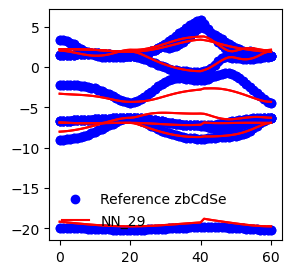

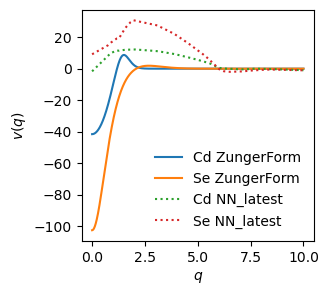

Loss: 0.4997098368741903
Parameter: input_layer.weight, Gradient Norm: 2.2396221170292677e-06
Parameter: input_layer.bias, Gradient Norm: 1.1056974425180449e-15
Parameter: bn1.weight, Gradient Norm: 0.30096315310994176
Parameter: bn1.bias, Gradient Norm: 0.2725203620096411
Parameter: hidden_layer1.weight, Gradient Norm: 0.11092608408584283
Parameter: hidden_layer1.bias, Gradient Norm: 1.9092508664462777e-16
Parameter: bn2.weight, Gradient Norm: 0.19871948197360523
Parameter: bn2.bias, Gradient Norm: 0.15607012140567092
Parameter: hidden_layer2.weight, Gradient Norm: 0.11682086139538692
Parameter: hidden_layer2.bias, Gradient Norm: 8.58404802414926e-17
Parameter: bn3.weight, Gradient Norm: 0.15939875270341206
Parameter: bn3.bias, Gradient Norm: 0.13833468003635555
Parameter: output_layer.weight, Gradient Norm: 0.19285063542232572
Parameter: output_layer.bias, Gradient Norm: 0.012710112001670857
Loss: 0.49741413498856946
Parameter: input_layer.weight, Gradient Norm: 2.19870803107055e-06


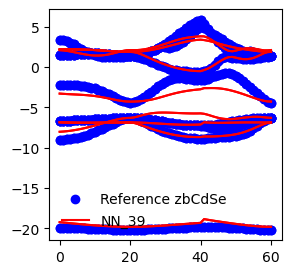

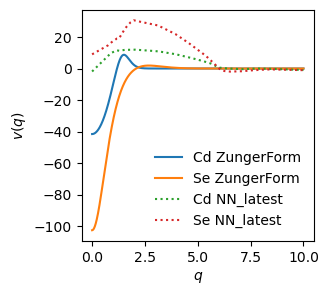

Loss: 0.47846581090163665
Parameter: input_layer.weight, Gradient Norm: 1.940391172352703e-06
Parameter: input_layer.bias, Gradient Norm: 2.0362671371842016e-15
Parameter: bn1.weight, Gradient Norm: 0.27795386112422293
Parameter: bn1.bias, Gradient Norm: 0.2331645809203108
Parameter: hidden_layer1.weight, Gradient Norm: 0.1404812761371058
Parameter: hidden_layer1.bias, Gradient Norm: 1.9135000308154557e-16
Parameter: bn2.weight, Gradient Norm: 0.18473040515972247
Parameter: bn2.bias, Gradient Norm: 0.11954667116959501
Parameter: hidden_layer2.weight, Gradient Norm: 0.1015279951900482
Parameter: hidden_layer2.bias, Gradient Norm: 3.692094637620127e-16
Parameter: bn3.weight, Gradient Norm: 0.22610033901859905
Parameter: bn3.bias, Gradient Norm: 0.14006474512867692
Parameter: output_layer.weight, Gradient Norm: 0.297092548781511
Parameter: output_layer.bias, Gradient Norm: 0.011236082712911903
Loss: 0.47652540534157695
Parameter: input_layer.weight, Gradient Norm: 1.8585942017017426e-06
P

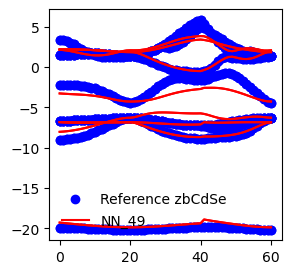

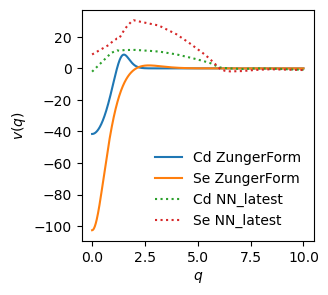

Loss: 0.4610482150138952
Parameter: input_layer.weight, Gradient Norm: 1.2030875281163146e-06
Parameter: input_layer.bias, Gradient Norm: 1.2096677463473654e-15
Parameter: bn1.weight, Gradient Norm: 0.20322909198969907
Parameter: bn1.bias, Gradient Norm: 0.21388335595090527
Parameter: hidden_layer1.weight, Gradient Norm: 0.10360095456310557
Parameter: hidden_layer1.bias, Gradient Norm: 5.574781857114629e-16
Parameter: bn2.weight, Gradient Norm: 0.17275166530887898
Parameter: bn2.bias, Gradient Norm: 0.11695342452332623
Parameter: hidden_layer2.weight, Gradient Norm: 0.08603745180049395
Parameter: hidden_layer2.bias, Gradient Norm: 3.094801816969271e-16
Parameter: bn3.weight, Gradient Norm: 0.18192214678769444
Parameter: bn3.bias, Gradient Norm: 0.11569924058651844
Parameter: output_layer.weight, Gradient Norm: 0.23865542008317603
Parameter: output_layer.bias, Gradient Norm: 0.00975169944501131


In [13]:
train_model(50)

Loss: 0.459502434481531
Parameter: input_layer.weight, Gradient Norm: 1.2343567301616545e-06
Parameter: input_layer.bias, Gradient Norm: 1.5380998030710309e-15
Parameter: bn1.weight, Gradient Norm: 0.2069634426119588
Parameter: bn1.bias, Gradient Norm: 0.20930433278433927
Parameter: hidden_layer1.weight, Gradient Norm: 0.10211517836592991
Parameter: hidden_layer1.bias, Gradient Norm: 1.530727514199434e-15
Parameter: bn2.weight, Gradient Norm: 0.1713609600119992
Parameter: bn2.bias, Gradient Norm: 0.11415586770114322
Parameter: hidden_layer2.weight, Gradient Norm: 0.08617179306404944
Parameter: hidden_layer2.bias, Gradient Norm: 4.683365383207992e-16
Parameter: bn3.weight, Gradient Norm: 0.1847901084006379
Parameter: bn3.bias, Gradient Norm: 0.11422946294704629
Parameter: output_layer.weight, Gradient Norm: 0.24295475118605378
Parameter: output_layer.bias, Gradient Norm: 0.009582860392055375
Loss: 0.4579785574818121
Parameter: input_layer.weight, Gradient Norm: 1.269948823670307e-06
Par

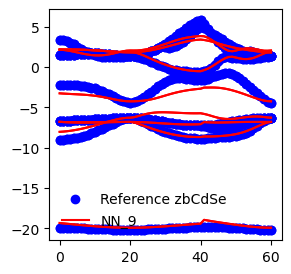

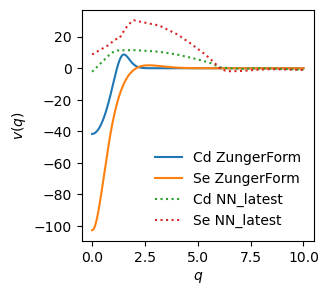

Loss: 0.44657027785638476
Parameter: input_layer.weight, Gradient Norm: 1.3198497155586496e-06
Parameter: input_layer.bias, Gradient Norm: 1.5884000651039813e-15
Parameter: bn1.weight, Gradient Norm: 0.20543795416344376
Parameter: bn1.bias, Gradient Norm: 0.17563390902850107
Parameter: hidden_layer1.weight, Gradient Norm: 0.09879865495312379
Parameter: hidden_layer1.bias, Gradient Norm: 9.650947684347157e-17
Parameter: bn2.weight, Gradient Norm: 0.1435917821263635
Parameter: bn2.bias, Gradient Norm: 0.0934407375676509
Parameter: hidden_layer2.weight, Gradient Norm: 0.07670798150694577
Parameter: hidden_layer2.bias, Gradient Norm: 3.492342365123938e-16
Parameter: bn3.weight, Gradient Norm: 0.1907692013126116
Parameter: bn3.bias, Gradient Norm: 0.10798188187718796
Parameter: output_layer.weight, Gradient Norm: 0.26045288588569726
Parameter: output_layer.bias, Gradient Norm: 0.008379981157693953
Loss: 0.44523930466488193
Parameter: input_layer.weight, Gradient Norm: 1.3142820089331404e-06

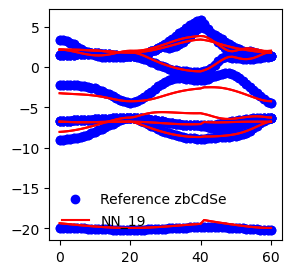

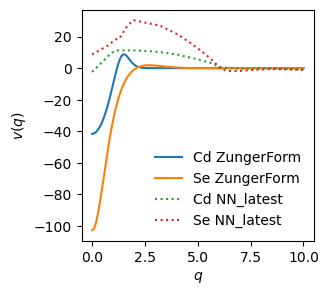

Loss: 0.4337331545820391
Parameter: input_layer.weight, Gradient Norm: 1.7046184756136391e-06
Parameter: input_layer.bias, Gradient Norm: 2.059287959951593e-15
Parameter: bn1.weight, Gradient Norm: 0.2292670905429771
Parameter: bn1.bias, Gradient Norm: 0.14815287900739793
Parameter: hidden_layer1.weight, Gradient Norm: 0.12559221500077888
Parameter: hidden_layer1.bias, Gradient Norm: 4.878974750355222e-16
Parameter: bn2.weight, Gradient Norm: 0.13176081313033794
Parameter: bn2.bias, Gradient Norm: 0.07600515249068551
Parameter: hidden_layer2.weight, Gradient Norm: 0.07480125420985005
Parameter: hidden_layer2.bias, Gradient Norm: 2.2591116691294622e-16
Parameter: bn3.weight, Gradient Norm: 0.2136950128900649
Parameter: bn3.bias, Gradient Norm: 0.1057296558693736
Parameter: output_layer.weight, Gradient Norm: 0.29814127579082567
Parameter: output_layer.bias, Gradient Norm: 0.007563595948948896
Loss: 0.43244403457029135
Parameter: input_layer.weight, Gradient Norm: 2.2975139729878406e-06


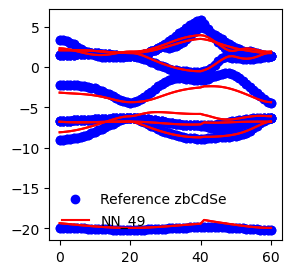

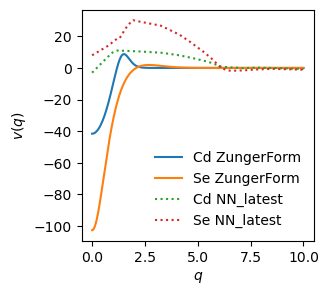

Loss: 0.3935339916052511
Parameter: input_layer.weight, Gradient Norm: 2.691079665388008e-06
Parameter: input_layer.bias, Gradient Norm: 1.7401180205406523e-15
Parameter: bn1.weight, Gradient Norm: 0.3461841456785343
Parameter: bn1.bias, Gradient Norm: 0.18564138641653172
Parameter: hidden_layer1.weight, Gradient Norm: 0.2524376580980823
Parameter: hidden_layer1.bias, Gradient Norm: 1.4187285596381512e-15
Parameter: bn2.weight, Gradient Norm: 0.14596210154064318
Parameter: bn2.bias, Gradient Norm: 0.06030902309220957
Parameter: hidden_layer2.weight, Gradient Norm: 0.08478834238729833
Parameter: hidden_layer2.bias, Gradient Norm: 3.72265845649725e-16
Parameter: bn3.weight, Gradient Norm: 0.263805494329214
Parameter: bn3.bias, Gradient Norm: 0.11224028073528809
Parameter: output_layer.weight, Gradient Norm: 0.34495529504591665
Parameter: output_layer.bias, Gradient Norm: 0.007549107273259238


In [14]:
train_model(50)

Loss: 0.30166848113815
Parameter: input_layer.weight, Gradient Norm: 1.5434257608404623e-06
Parameter: input_layer.bias, Gradient Norm: 1.4361252736976167e-15
Parameter: bn1.weight, Gradient Norm: 0.2465844341865336
Parameter: bn1.bias, Gradient Norm: 0.195928807817343
Parameter: hidden_layer1.weight, Gradient Norm: 0.18153657229876657
Parameter: hidden_layer1.bias, Gradient Norm: 1.4212541053026493e-15
Parameter: bn2.weight, Gradient Norm: 0.12008364419149968
Parameter: bn2.bias, Gradient Norm: 0.0749199770045804
Parameter: hidden_layer2.weight, Gradient Norm: 0.06889623171185572
Parameter: hidden_layer2.bias, Gradient Norm: 3.110836970201299e-16
Parameter: bn3.weight, Gradient Norm: 0.2084294362409316
Parameter: bn3.bias, Gradient Norm: 0.12174827607255456
Parameter: output_layer.weight, Gradient Norm: 0.28432848239337455
Parameter: output_layer.bias, Gradient Norm: 0.008321309843718306
Loss: 0.29981322135184635
Parameter: input_layer.weight, Gradient Norm: 1.5609710208916734e-06
Par

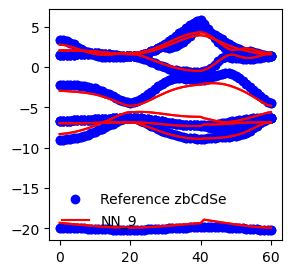

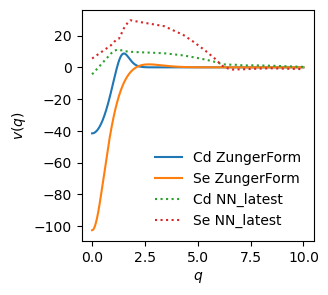

Loss: 0.285399448825088
Parameter: input_layer.weight, Gradient Norm: 1.6532652886591767e-06
Parameter: input_layer.bias, Gradient Norm: 1.0923281285906228e-15
Parameter: bn1.weight, Gradient Norm: 0.25699954141225895
Parameter: bn1.bias, Gradient Norm: 0.20652090973566536
Parameter: hidden_layer1.weight, Gradient Norm: 0.1362995393509808
Parameter: hidden_layer1.bias, Gradient Norm: 9.750190796724198e-16
Parameter: bn2.weight, Gradient Norm: 0.11470704560445504
Parameter: bn2.bias, Gradient Norm: 0.08734501347416718
Parameter: hidden_layer2.weight, Gradient Norm: 0.07253348881147914
Parameter: hidden_layer2.bias, Gradient Norm: 1.0514845328028141e-16
Parameter: bn3.weight, Gradient Norm: 0.1604783949362151
Parameter: bn3.bias, Gradient Norm: 0.11376759112805301
Parameter: output_layer.weight, Gradient Norm: 0.20807484679100494
Parameter: output_layer.bias, Gradient Norm: 0.008022956376517665
Loss: 0.2836696544676878
Parameter: input_layer.weight, Gradient Norm: 1.6284481293299576e-06


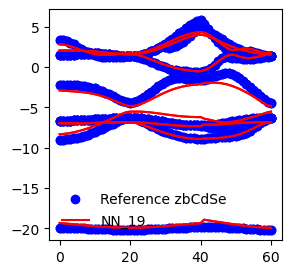

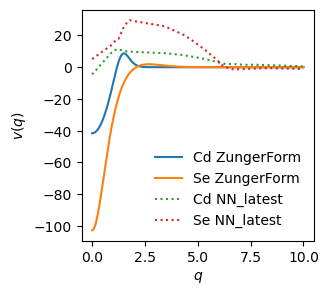

Loss: 0.26878590142131964
Parameter: input_layer.weight, Gradient Norm: 1.4416407360514315e-06
Parameter: input_layer.bias, Gradient Norm: 1.4884361534172818e-15
Parameter: bn1.weight, Gradient Norm: 0.21825105625133862
Parameter: bn1.bias, Gradient Norm: 0.1838332124989118
Parameter: hidden_layer1.weight, Gradient Norm: 0.09692057896836898
Parameter: hidden_layer1.bias, Gradient Norm: 2.93855325381438e-16
Parameter: bn2.weight, Gradient Norm: 0.11201899161393615
Parameter: bn2.bias, Gradient Norm: 0.08029638508854682
Parameter: hidden_layer2.weight, Gradient Norm: 0.06596989835182825
Parameter: hidden_layer2.bias, Gradient Norm: 1.9414632962166845e-16
Parameter: bn3.weight, Gradient Norm: 0.15904879814285436
Parameter: bn3.bias, Gradient Norm: 0.11078076101680881
Parameter: output_layer.weight, Gradient Norm: 0.20885467970888094
Parameter: output_layer.bias, Gradient Norm: 0.0076554313855112174
Loss: 0.26720575301450666
Parameter: input_layer.weight, Gradient Norm: 1.4209878925526777e

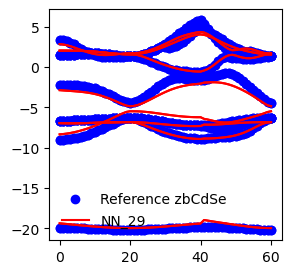

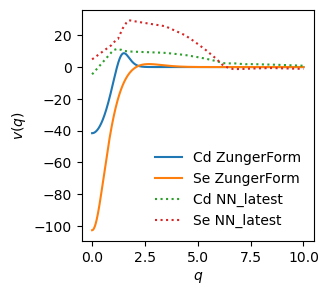

Loss: 0.2542167159789416
Parameter: input_layer.weight, Gradient Norm: 1.2215857743549275e-06
Parameter: input_layer.bias, Gradient Norm: 1.018556059092022e-15
Parameter: bn1.weight, Gradient Norm: 0.17995280618882112
Parameter: bn1.bias, Gradient Norm: 0.15927837452827834
Parameter: hidden_layer1.weight, Gradient Norm: 0.06441280879354075
Parameter: hidden_layer1.bias, Gradient Norm: 3.7847462385494505e-16
Parameter: bn2.weight, Gradient Norm: 0.09189637246209452
Parameter: bn2.bias, Gradient Norm: 0.07783836265188553
Parameter: hidden_layer2.weight, Gradient Norm: 0.06513730787036476
Parameter: hidden_layer2.bias, Gradient Norm: 9.330872737529454e-17
Parameter: bn3.weight, Gradient Norm: 0.11530237294350572
Parameter: bn3.bias, Gradient Norm: 0.08947551522210986
Parameter: output_layer.weight, Gradient Norm: 0.1486956337333877
Parameter: output_layer.bias, Gradient Norm: 0.006590610568929905
Loss: 0.2529259946066966
Parameter: input_layer.weight, Gradient Norm: 1.210158615677605e-06


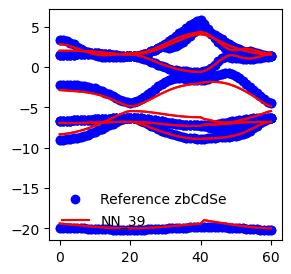

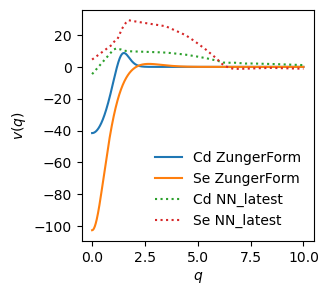

Loss: 0.24224741847216977
Parameter: input_layer.weight, Gradient Norm: 1.0287432995230994e-06
Parameter: input_layer.bias, Gradient Norm: 8.729414668800329e-16
Parameter: bn1.weight, Gradient Norm: 0.1472271304344521
Parameter: bn1.bias, Gradient Norm: 0.1353914364867406
Parameter: hidden_layer1.weight, Gradient Norm: 0.08122135647222413
Parameter: hidden_layer1.bias, Gradient Norm: 9.17876558846611e-16
Parameter: bn2.weight, Gradient Norm: 0.09760869120924492
Parameter: bn2.bias, Gradient Norm: 0.05829220694929948
Parameter: hidden_layer2.weight, Gradient Norm: 0.05268883180500587
Parameter: hidden_layer2.bias, Gradient Norm: 2.6265257432440243e-16
Parameter: bn3.weight, Gradient Norm: 0.15501058771651477
Parameter: bn3.bias, Gradient Norm: 0.08881358989531328
Parameter: output_layer.weight, Gradient Norm: 0.20949936962689727
Parameter: output_layer.bias, Gradient Norm: 0.0059882356934834085
Loss: 0.24114176774110657
Parameter: input_layer.weight, Gradient Norm: 1.0129783639307527e-0

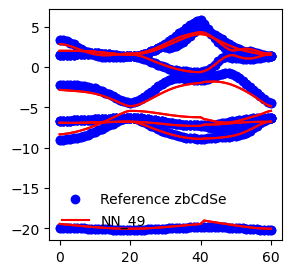

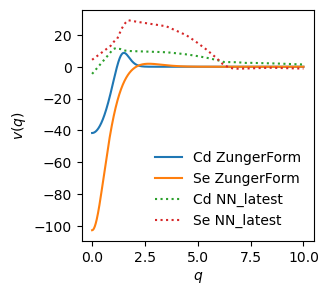

Loss: 0.2321670599275875
Parameter: input_layer.weight, Gradient Norm: 9.024626767951293e-07
Parameter: input_layer.bias, Gradient Norm: 3.0266204446868472e-16
Parameter: bn1.weight, Gradient Norm: 0.13013469645147163
Parameter: bn1.bias, Gradient Norm: 0.12228283446885571
Parameter: hidden_layer1.weight, Gradient Norm: 0.07461450040269674
Parameter: hidden_layer1.bias, Gradient Norm: 5.2367898734029555e-16
Parameter: bn2.weight, Gradient Norm: 0.09538056053313893
Parameter: bn2.bias, Gradient Norm: 0.04702540676611781
Parameter: hidden_layer2.weight, Gradient Norm: 0.04966300615558324
Parameter: hidden_layer2.bias, Gradient Norm: 1.7261837890179706e-16
Parameter: bn3.weight, Gradient Norm: 0.1409351994025228
Parameter: bn3.bias, Gradient Norm: 0.06944598683378402
Parameter: output_layer.weight, Gradient Norm: 0.18051834450202076
Parameter: output_layer.bias, Gradient Norm: 0.004903238880327241


In [18]:
train_model(50)

Loss: 0.23125051695155263
Parameter: input_layer.weight, Gradient Norm: 8.941249152061554e-07
Parameter: input_layer.bias, Gradient Norm: 4.4013281846279857e-16
Parameter: bn1.weight, Gradient Norm: 0.12879878125843594
Parameter: bn1.bias, Gradient Norm: 0.11986400561621056
Parameter: hidden_layer1.weight, Gradient Norm: 0.07952926101113267
Parameter: hidden_layer1.bias, Gradient Norm: 8.057373149244846e-17
Parameter: bn2.weight, Gradient Norm: 0.09711462815092041
Parameter: bn2.bias, Gradient Norm: 0.04483546801687504
Parameter: hidden_layer2.weight, Gradient Norm: 0.04937750877823435
Parameter: hidden_layer2.bias, Gradient Norm: 1.3597696624546456e-16
Parameter: bn3.weight, Gradient Norm: 0.14830534631857695
Parameter: bn3.bias, Gradient Norm: 0.06948192712118179
Parameter: output_layer.weight, Gradient Norm: 0.18998881401995246
Parameter: output_layer.bias, Gradient Norm: 0.00484948506277803
Loss: 0.230342343940474
Parameter: input_layer.weight, Gradient Norm: 8.86443177458509e-07
P

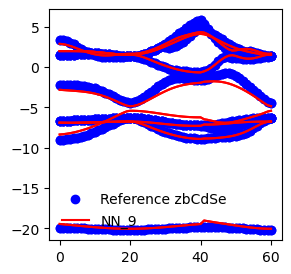

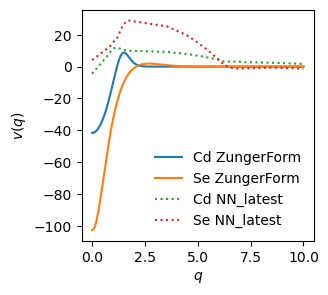

Loss: 0.22353046521076642
Parameter: input_layer.weight, Gradient Norm: 5.984716988748698e-07
Parameter: input_layer.bias, Gradient Norm: 6.358397016718946e-16
Parameter: bn1.weight, Gradient Norm: 0.08912450854315612
Parameter: bn1.bias, Gradient Norm: 0.11411941885749695
Parameter: hidden_layer1.weight, Gradient Norm: 0.05381960496921681
Parameter: hidden_layer1.bias, Gradient Norm: 8.934463377305758e-16
Parameter: bn2.weight, Gradient Norm: 0.10449768768217299
Parameter: bn2.bias, Gradient Norm: 0.0365433963193246
Parameter: hidden_layer2.weight, Gradient Norm: 0.0545198780278277
Parameter: hidden_layer2.bias, Gradient Norm: 1.4399379549166558e-16
Parameter: bn3.weight, Gradient Norm: 0.1710621812575603
Parameter: bn3.bias, Gradient Norm: 0.07524923650553533
Parameter: output_layer.weight, Gradient Norm: 0.2270688470851019
Parameter: output_layer.bias, Gradient Norm: 0.004740520388177016
Loss: 0.2227716453105103
Parameter: input_layer.weight, Gradient Norm: 6.006845765891607e-07
Par

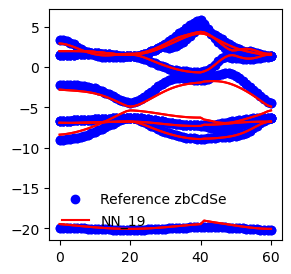

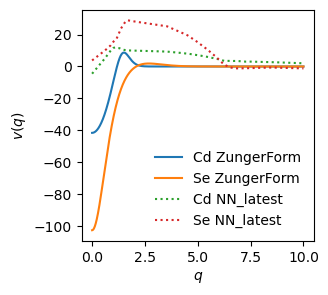

Loss: 0.21629589311105632
Parameter: input_layer.weight, Gradient Norm: 5.575910824293177e-07
Parameter: input_layer.bias, Gradient Norm: 3.536928810696967e-16
Parameter: bn1.weight, Gradient Norm: 0.09476491286472465
Parameter: bn1.bias, Gradient Norm: 0.1142961001209053
Parameter: hidden_layer1.weight, Gradient Norm: 0.05133033137389393
Parameter: hidden_layer1.bias, Gradient Norm: 1.3049119252003959e-15
Parameter: bn2.weight, Gradient Norm: 0.08783413634032847
Parameter: bn2.bias, Gradient Norm: 0.0418592125682181
Parameter: hidden_layer2.weight, Gradient Norm: 0.044767006985453224
Parameter: hidden_layer2.bias, Gradient Norm: 1.1222898256113188e-16
Parameter: bn3.weight, Gradient Norm: 0.1279978570490766
Parameter: bn3.bias, Gradient Norm: 0.06471452498456592
Parameter: output_layer.weight, Gradient Norm: 0.16628154030001474
Parameter: output_layer.bias, Gradient Norm: 0.004422390561570375
Loss: 0.21560781452397607
Parameter: input_layer.weight, Gradient Norm: 5.469656380749168e-07

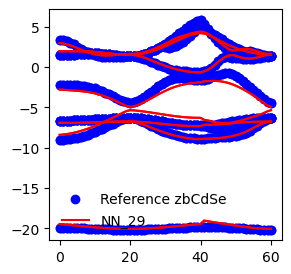

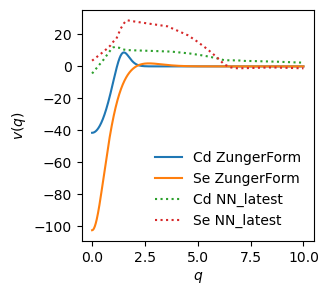

Loss: 0.20948994784683397
Parameter: input_layer.weight, Gradient Norm: 5.44059315130554e-07
Parameter: input_layer.bias, Gradient Norm: 6.871142012442468e-16
Parameter: bn1.weight, Gradient Norm: 0.0890142002724754
Parameter: bn1.bias, Gradient Norm: 0.11265221830724453
Parameter: hidden_layer1.weight, Gradient Norm: 0.04757357053937145
Parameter: hidden_layer1.bias, Gradient Norm: 1.4702769679665146e-15
Parameter: bn2.weight, Gradient Norm: 0.08783817606082366
Parameter: bn2.bias, Gradient Norm: 0.039820618117872686
Parameter: hidden_layer2.weight, Gradient Norm: 0.043506456982164536
Parameter: hidden_layer2.bias, Gradient Norm: 6.274265627385488e-17
Parameter: bn3.weight, Gradient Norm: 0.132577585519428
Parameter: bn3.bias, Gradient Norm: 0.067415139244947
Parameter: output_layer.weight, Gradient Norm: 0.17695555004417848
Parameter: output_layer.bias, Gradient Norm: 0.004456815425070088
Loss: 0.2088160945532663
Parameter: input_layer.weight, Gradient Norm: 5.412359840853343e-07
Par

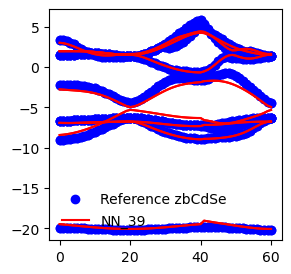

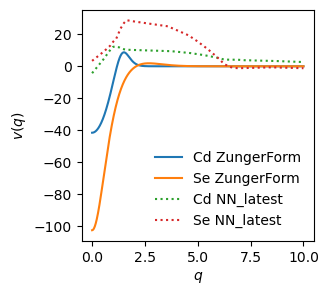

Loss: 0.20291024074446168
Parameter: input_layer.weight, Gradient Norm: 5.364275038323978e-07
Parameter: input_layer.bias, Gradient Norm: 3.3302258680300995e-16
Parameter: bn1.weight, Gradient Norm: 0.09413547766851688
Parameter: bn1.bias, Gradient Norm: 0.11197392031402828
Parameter: hidden_layer1.weight, Gradient Norm: 0.04904352624494306
Parameter: hidden_layer1.bias, Gradient Norm: 6.484754873558698e-16
Parameter: bn2.weight, Gradient Norm: 0.07624905765491463
Parameter: bn2.bias, Gradient Norm: 0.04243450779690731
Parameter: hidden_layer2.weight, Gradient Norm: 0.04251364343141461
Parameter: hidden_layer2.bias, Gradient Norm: 1.4055133858957566e-16
Parameter: bn3.weight, Gradient Norm: 0.10766827288320885
Parameter: bn3.bias, Gradient Norm: 0.0613366413412335
Parameter: output_layer.weight, Gradient Norm: 0.14291290500944456
Parameter: output_layer.bias, Gradient Norm: 0.004135847648360436
Loss: 0.20227157616844954
Parameter: input_layer.weight, Gradient Norm: 5.378331359192419e-0

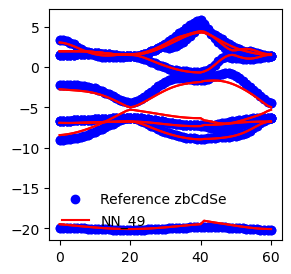

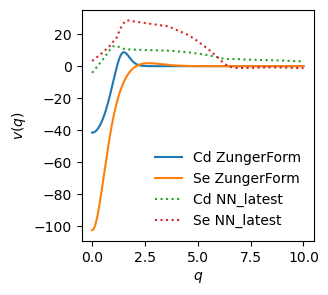

Loss: 0.1966914463576074
Parameter: input_layer.weight, Gradient Norm: 4.877051127443317e-07
Parameter: input_layer.bias, Gradient Norm: 3.7637111756881927e-16
Parameter: bn1.weight, Gradient Norm: 0.0851695297669975
Parameter: bn1.bias, Gradient Norm: 0.10617397906909884
Parameter: hidden_layer1.weight, Gradient Norm: 0.04178459508244649
Parameter: hidden_layer1.bias, Gradient Norm: 1.8537169878495224e-16
Parameter: bn2.weight, Gradient Norm: 0.07280971318210804
Parameter: bn2.bias, Gradient Norm: 0.03869811147636091
Parameter: hidden_layer2.weight, Gradient Norm: 0.03987939769864165
Parameter: hidden_layer2.bias, Gradient Norm: 1.2633703345317404e-16
Parameter: bn3.weight, Gradient Norm: 0.10504606769862644
Parameter: bn3.bias, Gradient Norm: 0.05994484142916752
Parameter: output_layer.weight, Gradient Norm: 0.14262848546590223
Parameter: output_layer.bias, Gradient Norm: 0.003919116029429566


In [19]:
train_model(50)

In [20]:
torch.save(PPmodel.state_dict(), 'PPmodel_1_20_20_2_run310.pth')

loaded_model = Net()
loaded_model.load_state_dict(torch.load('PPmodel_1_20_20_2_run310.pth'))

<All keys matched successfully>